# 6. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기


## 목차

> <p style="font-size:17px">5.1 데이터 다운로드</p>
  <p style="font-size:17px">5.2 데이터 읽어오기</p> 
  <p style="font-size:17px">5.3 데이터 정제</p>
  <p style="font-size:17px">5.4 평가 데이터셋 분리</p>
  <p style="font-size:17px">5.5 인공지능 만들기</p>


## 루브릭 (프로젝트 평가 기준)

> |<p style="font-size:15px"> 평가문항 </p>                                |<p style="font-size:15px"> 상세기준 </p>        |
  |------------------------------------------------------------------------|------------------------------------------------|
  | 1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다. |3가지 이상의 모델이 성공적으로 시도됨           |
  | 2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다. |gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함|
  | 3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.            |네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함|

## 1) 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from konlpy.tag import Mecab

# data 읽어오기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성

In [2]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
# stopwords: 불용어

# Data loader 함수
def load_data(train_data, test_data, num_words=10000):
    # train data 전처리
    # 중복, 특수문자 제거, 공백을 NULL로 변경, 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    train_data['document'].replace('', np.nan, inplace=True)
    train_data = train_data.dropna(how = 'any')

    # test data 전처리
    # 중복, 특수문자 제거, 공백을 NULL로 변경, 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    test_data['document'].replace('', np.nan, inplace=True)
    test_data = test_data.dropna(how = 'any')

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 삭제
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) #토큰화
        temp_X = [word for word in temp_X if not word in stopwords] #불용어 삭제
        X_test.append(temp_X)
    
    # 단어 사전
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 텍스트를 단어 사전 인덱스로 변환하는 함수
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print("train data 개수: {}, test data 개수: {}".format(len(X_train), len(X_test)))



/tmp/ipykernel_1497/1419305838.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
/tmp/ipykernel_1497/1419305838.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


train data 개수: 145791, test data 개수: 48995


In [3]:
# 사전 딕셔너리 생성
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델 구성을 위한 데이터 분석 및 가공

In [5]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장 길이 평균     : ', np.mean(num_tokens))
print('문장 길이 최대     : ', np.max(num_tokens))
print('문장 길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함'.format(np.sum(num_tokens < max_tokens) / len(num_tokens) *100))

문장 길이 평균     :  13.757179674103888
문장 길이 최대     :  83
문장 길이 표준편차 :  11.462771769216866
pad_sequences maxlen :  36
전체 문장의 93.38145451931864%가 maxlen 설정값 이내에 포함


In [6]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                       value=word_to_index["<PAD>"],
                                       padding='post',
                                       maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                       value=word_to_index["<PAD>"],
                                       padding='post',
                                       maxlen=maxlen)

print(X_train.shape)

(145791, 36)


In [7]:
# validation set 43747건 분리
x_val = X_train[:43747]   
y_val = y_train[:43747]

# validation set을 제외한 나머지 102044건
partial_x_train = X_train[43747:]  
partial_y_train = y_train[43747:]

print(partial_x_train.shape)
print(x_val.shape)
print(partial_y_train.shape)
print(y_val.shape)

(102044, 36)
(43747, 36)
(102044,)
(43747,)


In [8]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_rnn.add(keras.layers.Dense(8, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [9]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_rnn = model_rnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
200/200 [==============================] - 5s 8ms/step - loss: 0.5616 - accuracy: 0.7022 - val_loss: 0.4058 - val_accuracy: 0.8275
Epoch 2/20
200/200 [==============================] - 1s 6ms/step - loss: 0.3642 - accuracy: 0.8450 - val_loss: 0.3633 - val_accuracy: 0.8402
Epoch 3/20
200/200 [==============================] - 1s 6ms/step - loss: 0.3337 - accuracy: 0.8590 - val_loss: 0.3665 - val_accuracy: 0.8366
Epoch 4/20
200/200 [==============================] - 1s 6ms/step - loss: 0.3190 - accuracy: 0.8661 - val_loss: 0.3635 - val_accuracy: 0.8392
Epoch 5/20
200/200 [==============================] - 1s 6ms/step - loss: 0.3114 - accuracy: 0.8699 - val_loss: 0.3739 - val_accuracy: 0.8394
Epoch 6/20
200/200 [==============================] - 1s 6ms/step - loss: 0.3036 - accuracy: 0.8727 - val_loss: 0.3680 - val_accuracy: 0.8392
Epoch 7/20
200/200 [==============================] - 1s 6ms/step - loss: 0.2962 - accuracy: 0.8760 - val_loss: 0.3804 - val_accuracy: 0.8350
Epoch 

In [10]:
results = model_rnn.evaluate(X_test,  y_test, verbose=2)

print(results)

1532/1532 - 3s - loss: 0.5505 - accuracy: 0.8227
[0.5504716038703918, 0.8226757645606995]


In [11]:
history_rnn_dict = history_rnn.history
print(history_rnn_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


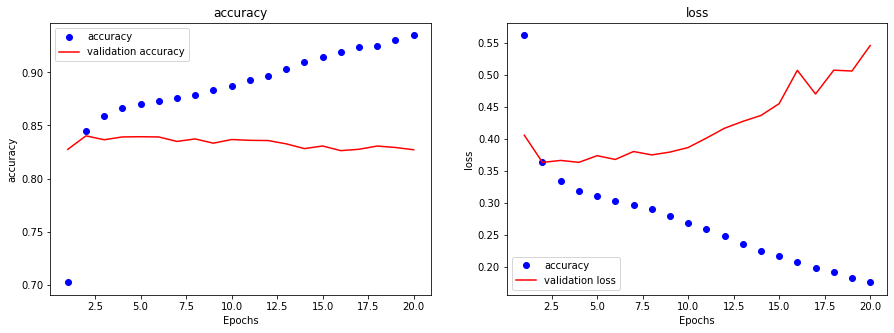

In [12]:
import matplotlib.pyplot as plt

acc = history_rnn_dict['accuracy']
val_acc = history_rnn_dict['val_accuracy']
loss = history_rnn_dict['loss']
val_loss = history_rnn_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='accuracy')
plt.plot(epochs, val_acc, 'red', label='validation accuracy')
plt.title('accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='accuracy')
plt.plot(epochs, val_loss, 'red', label='validation loss')
plt.title('loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

In [13]:

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 

# 모델 구성
model_1dcnn = keras.Sequential()
model_1dcnn.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 input_shape=(None,)))
model_1dcnn.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_1dcnn.add(keras.layers.MaxPooling1D(5))
model_1dcnn.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_1dcnn.add(keras.layers.GlobalMaxPooling1D())
model_1dcnn.add(keras.layers.Dense(8, activation='relu'))
model_1dcnn.add(keras.layers.Dense(1, activation='sigmoid')) 

model_1dcnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [14]:
# 학습의 진행
model_1dcnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_1dcnn = model_1dcnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
200/200 [==============================] - 3s 6ms/step - loss: 0.5255 - accuracy: 0.7517 - val_loss: 0.3737 - val_accuracy: 0.8349
Epoch 2/20
200/200 [==============================] - 1s 5ms/step - loss: 0.3460 - accuracy: 0.8505 - val_loss: 0.3567 - val_accuracy: 0.8429
Epoch 3/20
200/200 [==============================] - 1s 5ms/step - loss: 0.3096 - accuracy: 0.8691 - val_loss: 0.3620 - val_accuracy: 0.8432
Epoch 4/20
200/200 [==============================] - 1s 5ms/step - loss: 0.2838 - accuracy: 0.8829 - val_loss: 0.3688 - val_accuracy: 0.8409
Epoch 5/20
200/200 [==============================] - 1s 5ms/step - loss: 0.2599 - accuracy: 0.8956 - val_loss: 0.3784 - val_accuracy: 0.8397
Epoch 6/20
200/200 [==============================] - 1s 5ms/step - loss: 0.2346 - accuracy: 0.9075 - val_loss: 0.3937 - val_accuracy: 0.8371
Epoch 7/20
200/200 [==============================] - 1s 5ms/step - loss: 0.2094 - accuracy: 0.9204 - val_loss: 0.4151 - val_accuracy: 0.8350
Epoch 

In [15]:
results = model_1dcnn.evaluate(X_test,  y_test, verbose=2)

print(results)

1532/1532 - 2s - loss: 0.9423 - accuracy: 0.8026
[0.9423428773880005, 0.80255126953125]


In [16]:
history_1dcnn_dict = history_1dcnn.history
print(history_1dcnn_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


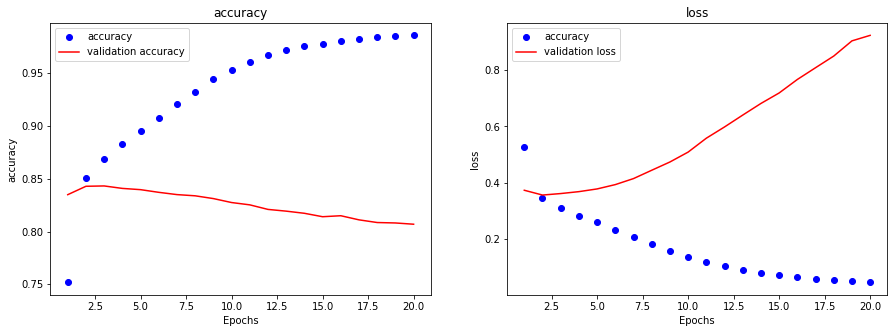

In [17]:
import matplotlib.pyplot as plt

acc = history_1dcnn_dict['accuracy']
val_acc = history_1dcnn_dict['val_accuracy']
loss = history_1dcnn_dict['loss']
val_loss = history_1dcnn_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='accuracy')
plt.plot(epochs, val_acc, 'red', label='validation accuracy')
plt.title('accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='accuracy')
plt.plot(epochs, val_loss, 'red', label='validation loss')
plt.title('loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

In [18]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_gmp = keras.Sequential()
model_gmp.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp.add(keras.layers.GlobalMaxPooling1D())
model_gmp.add(keras.layers.Dense(8, activation='relu'))
model_gmp.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_gmp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [19]:
# 학습의 진행
model_gmp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_gmp = model_gmp.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
200/200 [==============================] - 1s 4ms/step - loss: 0.6216 - accuracy: 0.7581 - val_loss: 0.4834 - val_accuracy: 0.8096
Epoch 2/20
200/200 [==============================] - 1s 4ms/step - loss: 0.4094 - accuracy: 0.8281 - val_loss: 0.3794 - val_accuracy: 0.8321
Epoch 3/20
200/200 [==============================] - 1s 4ms/step - loss: 0.3464 - accuracy: 0.8531 - val_loss: 0.3640 - val_accuracy: 0.8375
Epoch 4/20
200/200 [==============================] - 1s 4ms/step - loss: 0.3157 - accuracy: 0.8685 - val_loss: 0.3611 - val_accuracy: 0.8401
Epoch 5/20
200/200 [==============================] - 1s 4ms/step - loss: 0.2931 - accuracy: 0.8799 - val_loss: 0.3631 - val_accuracy: 0.8408
Epoch 6/20
200/200 [==============================] - 1s 4ms/step - loss: 0.2748 - accuracy: 0.8882 - val_loss: 0.3689 - val_accuracy: 0.8417
Epoch 7/20
200/200 [==============================] - 1s 4ms/step - loss: 0.2588 - accuracy: 0.8958 - val_loss: 0.3772 - val_accuracy: 0.8407
Epoch 

In [20]:
results = model_gmp.evaluate(X_test,  y_test, verbose=2)

print(results)

1532/1532 - 2s - loss: 0.5593 - accuracy: 0.8189
[0.5592678785324097, 0.8189406991004944]


In [21]:
history_gmp_dict = history_gmp.history
print(history_gmp_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


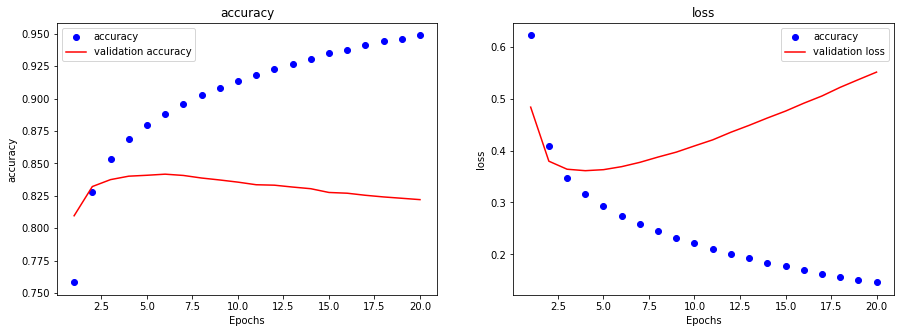

In [22]:
import matplotlib.pyplot as plt

acc = history_gmp_dict['accuracy']
val_acc = history_gmp_dict['val_accuracy']
loss = history_gmp_dict['loss']
val_loss = history_gmp_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='accuracy')
plt.plot(epochs, val_acc, 'red', label='validation accuracy')
plt.title('accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='accuracy')
plt.plot(epochs, val_loss, 'red', label='validation loss')
plt.title('loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

In [23]:
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

embedding_layer = model_rnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [24]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_rnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [25]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([ 0.04293397, -0.00620962,  0.01167466, -0.10735663, -0.06107241,
        0.16141713,  0.06476311,  0.07128425, -0.05947423, -0.09827703,
        0.13039535,  0.09641946, -0.11708685,  0.03784399, -0.09062321,
       -0.0613883 ], dtype=float32)

In [26]:
word_vectors.similar_by_word("사랑")

[('밖에', 0.9079948663711548),
 ('전해', 0.9078454971313477),
 ('순수', 0.899894654750824),
 ('눈물', 0.8950660228729248),
 ('통쾌', 0.8901728987693787),
 ('소름', 0.8899068832397461),
 ('더라구요', 0.889876663684845),
 ('천재', 0.886942446231842),
 ('힐링', 0.8821571469306946),
 ('최종', 0.8781214952468872)]

! pip install --upgrade gensim==3.8.3

In [28]:
import gensim
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['사랑']
vector     # 무려 300dim의 워드 벡터입니다.

/tmp/ipykernel_1497/1316910597.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['사랑']


array([-1.3740246 , -1.7353463 ,  3.3915305 , -2.569253  , -1.4016607 ,
        1.4556127 ,  0.9414557 ,  1.9207907 ,  0.16471806,  0.4838317 ,
       -0.8547181 ,  2.0879807 ,  0.86741775,  0.87539405, -0.09962013,
        0.22928311, -1.1858722 ,  0.00858838,  1.4999928 , -0.16196461,
       -0.35184434, -0.92390764,  1.0849575 ,  0.3025011 ,  2.7021565 ,
       -1.0263684 ,  0.32864776, -0.76589465, -2.510981  , -0.66225356,
        2.8434615 ,  0.50130975, -1.021874  , -1.4366034 ,  1.1110784 ,
        0.5812605 , -0.5830406 , -0.5785423 ,  1.3634988 ,  2.3074338 ,
       -1.4314893 ,  0.45745876,  1.1073523 , -3.2135262 , -0.2898375 ,
       -1.1622221 ,  1.2369208 , -0.7622987 , -0.37757635,  1.1376442 ,
        0.01065568, -0.69105595,  1.5159112 ,  1.1534518 , -1.0119992 ,
       -0.5757404 ,  1.1349088 , -1.1289831 ,  0.13004152,  2.0451715 ,
       -0.23940353,  1.3604902 ,  0.72700524,  0.32545742,  1.0612459 ,
        0.42252553,  1.1442151 ,  2.8774905 ,  2.4377263 , -1.34

In [35]:
word2vec.similar_by_word("사랑")

/tmp/ipykernel_1497/1360476464.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("사랑")


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [36]:
word2vec.similar_by_word("이별")

/tmp/ipykernel_1497/1195740980.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("이별")


[('헤어지', 0.6900225877761841),
 ('슬픔', 0.6873862147331238),
 ('추억', 0.6457439661026001),
 ('슬프', 0.6412862539291382),
 ('재회', 0.6345380544662476),
 ('사랑', 0.6334798336029053),
 ('첫사랑', 0.6128619909286499),
 ('고독', 0.6117805242538452),
 ('절망', 0.5997450947761536),
 ('작별', 0.5857374668121338)]

In [37]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_1497/1730871920.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_1497/1730871920.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [39]:
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen,
                                 trainable=True))
model.add(keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 36, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
1595/1595 [==============================] - 11s 6ms/step - loss: 0.4412 - accuracy: 0.7784 - val_loss: 0.3488 - val_accuracy: 0.8464
Epoch 2/20
1595/1595 [==============================] - 10s 6ms/step - loss: 0.3104 - accuracy: 0.8659 - val_loss: 0.3321 - val_accuracy: 0.8548
Epoch 3/20
1595/1595 [==============================] - 10s 6ms/step - loss: 0.2629 - accuracy: 0.8892 - val_loss: 0.3310 - val_accuracy: 0.8588
Epoch 4/20
1595/1595 [==============================] - 10s 6ms/step - loss: 0.2212 - accuracy: 0.9084 - val_loss: 0.3464 - val_accuracy: 0.8556
Epoch 5/20
1595/1595 [==============================] - 10s 6ms/step - loss: 0.1824 - accuracy: 0.9273 - val_loss: 0.3841 - val_accuracy: 0.8563
Epoch 6/20
1595/1595 [==============================] - 10s 6ms/step - loss: 0.1468 - accuracy: 0.9433 - val_loss: 0.4308 - val_accuracy: 0.8530
Epoch 7/20
1595/1595 [==============================] - 10s 6ms/step - loss: 0.1170 - accuracy: 0.9563 - val_loss: 0.4785 - val_ac

In [41]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1532/1532 - 3s - loss: 0.8354 - accuracy: 0.8375
[0.8354032635688782, 0.8374528288841248]


In [42]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


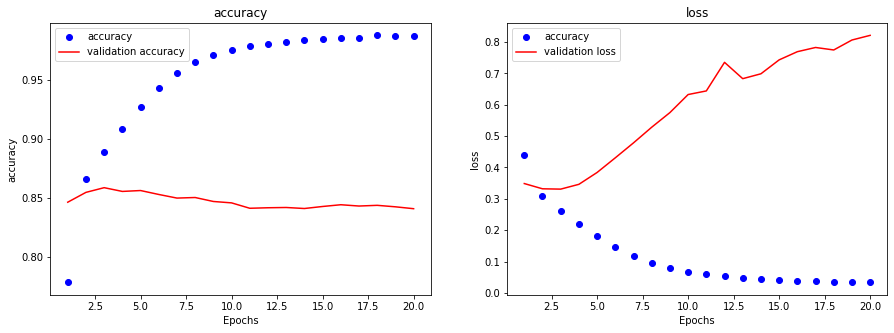

In [43]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='accuracy')
plt.plot(epochs, val_acc, 'red', label='validation accuracy')
plt.title('accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='accuracy')
plt.plot(epochs, val_loss, 'red', label='validation loss')
plt.title('loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.show()